In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/PALMS_SAMPLES/train_yolo3.csv')
labels.head()

image_id  width  height    X    Y    W    H               bbox source
0  000000000.png   1000    1000  827  543  144  151  [827,543,144,151]   palm
1  000000000.png   1000    1000  690  656  103  102  [690,656,103,102]   palm
2  000000000.png   1000    1000  831  713  146  161  [831,713,146,161]   palm
3  000000000.png   1000    1000  642  791  172  185  [642,791,172,185]   palm
4  000000001.png   1000    1000  814  528  101  117  [814,528,101,117]   palm

In [4]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

labels = labels.groupby('image_id').apply(group_boxes)

In [6]:
labels['000000001.png'][:]

array([[814., 528., 101., 117.],
       [575., 566., 160., 170.],
       [455., 628., 104., 116.],
       [309., 544., 155., 158.],
       [195., 655., 100., 111.],
       [322., 718., 159., 159.],
       [604., 718., 110., 130.],
       [445., 829., 120., 114.],
       [132., 815., 174., 168.],
       [783., 840., 118., 139.]])

In [32]:
train_image_ids = np.unique(labels.index.values)[0:450]
val_image_ids = np.unique(labels.index.values)[450:]

In [5]:
#Membuat fungsi untuk load image
def load_image(image_id):
    image = Image.open('/content/drive/MyDrive/PALMS_SAMPLES/' + image_id)
    image = image.resize((250, 250))
    
    return np.asarray(image)

In [33]:
#Loading Data Image ke dalam variable
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy() * (250/1000)

In [34]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = labels[image_id].copy() * (250/1000)

VISUALIZED

In [6]:
def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

def draw_bboxes(image_id, bboxes):  
    image = Image.open('/content/drive/MyDrive/PALMS_SAMPLES/' + image_id )
    image = image.resize((250,250))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)

In [7]:
def show_images(image_ids, bboxes):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id])
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

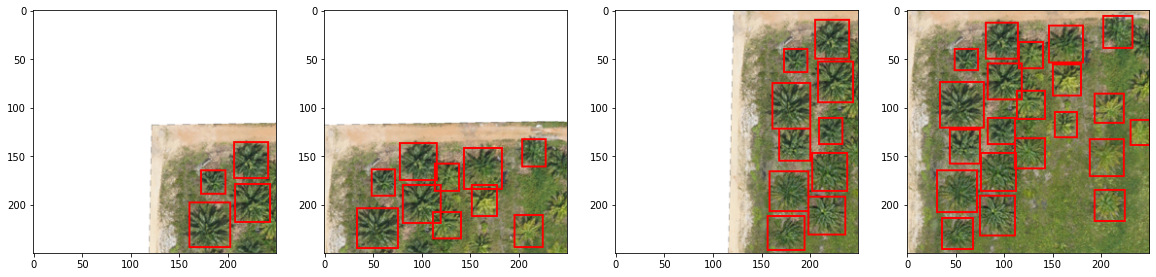

In [21]:
show_images(train_image_ids[0:4], train_labels)

In [22]:
train_labels['000000000.png'][:]

array([[206.75, 135.75,  36.  ,  37.75],
       [172.5 , 164.  ,  25.75,  25.5 ],
       [207.75, 178.25,  36.5 ,  40.25],
       [160.5 , 197.75,  43.  ,  46.25]])

PIPELINE

In [31]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 250 / 32, 250 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

In [9]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

In [10]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(250, 250), 
            height=250, 
            width=250, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [30]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [29]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 500
    box_height = box_height / 500

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [35]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=1, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=1,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [38]:
image_grid.shape

(32, 32, 4)

MODEL

In [14]:
x_input = tf.keras.Input(shape=(250,250,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 250, 250, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 250, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 250, 250, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [17]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [18]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_ckpt.weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_weights_only=True), \
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1), \
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True), \
]

In [35]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
450/450 [==============================] - 222s 404ms/step - loss: 0.2412 - val_loss: 0.1431

Epoch 00001: saving model to /content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_ckpt.weights.01-0.14.hdf5
Epoch 2/100
450/450 [==============================] - 184s 409ms/step - loss: 0.1031 - val_loss: 0.1196

Epoch 00002: saving model to /content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_ckpt.weights.02-0.12.hdf5
Epoch 3/100
450/450 [==============================] - 183s 408ms/step - loss: 0.0680 - val_loss: 0.1046

Epoch 00003: saving model to /content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_ckpt.weights.03-0.10.hdf5
Epoch 4/100
450/450 [==============================] - 184s 408ms/step - loss: 0.0539 - val_loss: 0.2179

Epoch 00004: saving model to /content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_ckpt.weights.04-0.22.hdf5
Epoch 5/100
450/450 [==============================] - 184s 408ms/step - loss: 0.0478 - val_loss: 0.0954

Epoch 0000

In [37]:
model.save_weights('/content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_model')

In [38]:
model.save('/content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_model_testing.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
model.load_weights('/content/drive/MyDrive/PALMS_SAMPLES/models/palms_detection_model_testing.h5')

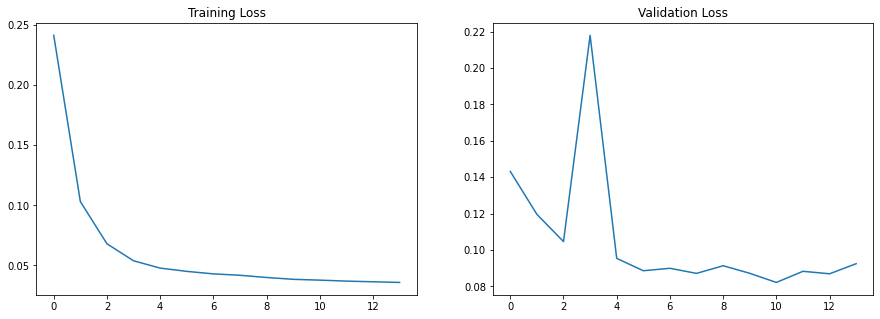

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

PREDICT

In [20]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

In [21]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

In [22]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

In [43]:
test_image_ids = os.listdir('/content/drive/MyDrive/PALMS_SAMPLES/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids[:10]]

In [44]:
test_predictions = []

for i, image_id in enumerate(test_image_ids):
    image = Image.open('/content/drive/MyDrive/PALMS_SAMPLES/' + image_id + ".png")
    image = image.resize((250, 250))            

    pixels = np.asarray(image)

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    test_predictions.append(bboxes)
    
test_predictions = np.concatenate(test_predictions)

In [45]:
test_predictions = process_predictions(test_predictions, test_image_ids, image_grid)

In [46]:
def show_images(image_ids, bboxes):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id + ".png", bboxes[image_id])
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

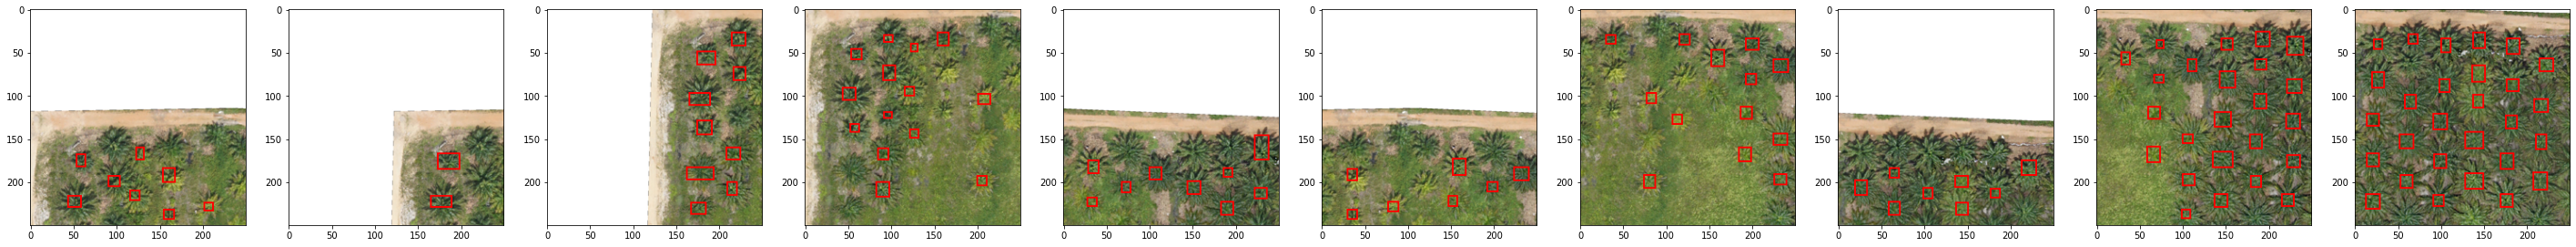

In [47]:
show_images(test_image_ids[0:10], test_predictions)

FUNGSI DETEKSI

In [23]:
def predict (path):
    test_predictions = []
    image = Image.open(path)
    image = image.resize((250, 250))            

    pixels = np.asarray(image)

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    #test_predictions.append(bboxes)
    
    test_predictions = np.concatenate(bboxes)
    
    return test_predictions

In [24]:
def process_predictions(predictions, image_grid):
    bboxes = {}
    
    predictions = prediction_to_bbox(predictions, image_grid)
    bboxes = non_max_suppression(predictions, top_n=100)
        
   # back to coco shape
    bboxes[:,2:4] = bboxes[:,2:4] - bboxes[:,0:2]
    
    return bboxes

In [25]:
def draw_bboxes(path, bboxes):  
    image = Image.open(path)
    image = image.resize((250,250))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)

In [26]:
def show_predict(path):
  bbox = predict(path)
  bbox = prediction_to_bbox(bbox, image_grid)
  bbox = non_max_suppression(bbox, top_n=100)
  #convert to yolo
  bbox[:,2:4] = bbox[:,2:4] - bbox[:,0:2]

  #show result
  pixels = draw_bboxes(path, bbox)
  plt.imshow(pixels)


   

In [130]:
bbox = predict('/content/drive/MyDrive/PALMS_SAMPLES/000000042.png')
bbox.shape

(32, 32, 10)

In [131]:
bbox = prediction_to_bbox(bbox, image_grid)
bbox.shape

(32, 32, 10)

In [133]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes, probabilities

In [134]:
bbox, prob = non_max_suppression(bbox, top_n=100)
bbox.shape

(21, 4)

In [135]:
prob.shape[0]

21

In [116]:
prob = np.reshape(prob, (21, -1))

In [117]:
prob.shape

(21, 1)

In [118]:
bbox = np.hstack((bbox, prob))

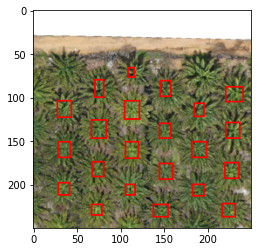

In [39]:
show_predict('/content/drive/MyDrive/PALMS_SAMPLES/000000042.png')

In [40]:
fotoudara =  Image.open('/content/drive/MyDrive/PALMS_SAMPLES/fotoudara/Tile.tif')

In [41]:
pixels = np.asarray(fotoudara)

In [42]:
pixels.shape

(3602, 12349, 3)

In [43]:
pixels = pixels[:3000,:12000]
pixels.shape

(3000, 12000, 3)

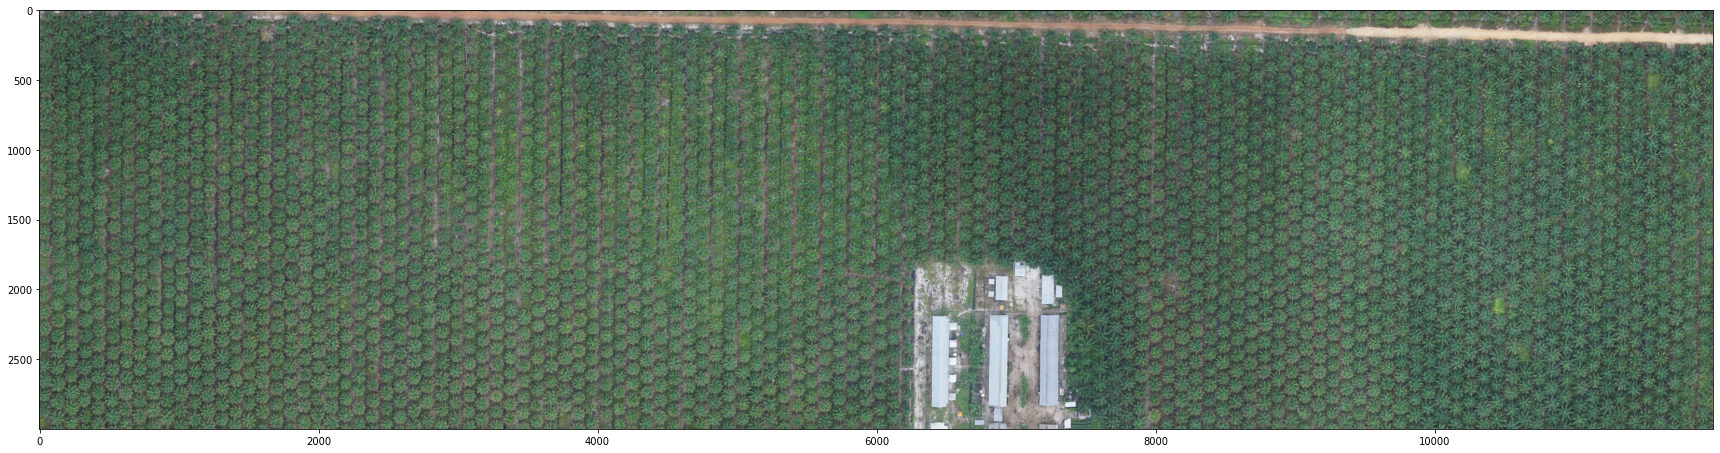

In [44]:
plt.figure(figsize = (30,15))
plt.imshow(pixels)

DETECT TILE

In [45]:
import PIL
from PIL import Image
import cv2

In [46]:
image = pixels
image_size = 1000

In [94]:
def detect (pixels):
    test_predictions = []

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    #test_predictions.append(bboxes)
    
    test_predictions = np.concatenate(bboxes)
    
    return test_predictions

In [91]:
image =  Image.open('/content/drive/MyDrive/PALMS_SAMPLES/fotoudara/Tile.tif')
image = np.asarray(image)
image = image[:3000,:12000]

In [92]:
image.shape

(3000, 12000, 3)

In [93]:
array = np.empty((0,5), dtype='float')
array.shape

(0, 5)

In [139]:
sample_size = 1000
array = np.empty((0,4), dtype='float')
result = []
for row in range(0,  image.shape[0], 500):
  for col in range (0, image.shape[1], 500):
    xo = col
    yo = row
    img= image[row:row+image_size,  col : col+ image_size]
    img = Image.fromarray(img, 'RGB')
    img = img.resize((250, 250))
    pixels = np.asarray(img)

    hasil = detect(pixels)

    hasil = prediction_to_bbox(hasil, image_grid)

    bbox, prob = non_max_suppression(hasil, top_n=100)
    #prob = np.reshape(prob, (prob.shape[0], -1))
    #bbox = np.hstack((bbox, prob))

    bbox[:,2:4] = bbox[:,2:4] - bbox[:,0:2]


    bbox[:,0] += col/4
    bbox[:,1] += row/4

    


    objects = bbox

    bbox[:,1] = 1000 - (objects[:,1] + objects[:,3])
    bbox[:,2] = objects[:,0] + objects[:,2]
    bbox[:,3] = objects[:,1] + objects[:,3]





    result.append(bbox)
    array = np.vstack((array,bbox))




   
    

In [140]:
array

array([[ 130.9949646 ,  803.37573242,  143.32868958,  812.87805176],
       [ 178.65661621,  965.38671875,  190.87158203,  978.89630127],
       [ 154.15768433,  816.13586426,  167.41572571,  829.32666016],
       ...,
       [2973.49755859,  233.23718262, 2987.49755859,  245.41256714],
       [2926.68457031,  140.0010376 , 2939.98168945,  150.73542786],
       [2889.24389648,  350.01092529, 2898.43896484,  360.91812134]])

In [141]:
array.shape

(8134, 4)

In [142]:
# import the necessary packages
import numpy as np
#  Felzenszwalb et al.
def nms(boxes, overlapThresh):
   # if there are no boxes, return an empty list
   if len(boxes) == 0:
      return []
   # initialize the list of picked indexes
   pick = []
   # grab the coordinates of the bounding boxes
   x1 = boxes[:,0]
   y1 = boxes[:,1]
   x2 = boxes[:,2]
   y2 = boxes[:,3]
   # compute the area of the bounding boxes and sort the bounding
   # boxes by the bottom-right y-coordinate of the bounding box
   area = (x2 - x1 + 1) * (y2 - y1 + 1)
   idxs = np.argsort(y2)
   # keep looping while some indexes still remain in the indexes
   # list
   while len(idxs) > 0:
      # grab the last index in the indexes list, add the index
      # value to the list of picked indexes, then initialize
      # the suppression list (i.e. indexes that will be deleted)
      # using the last index
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)
      suppress = [last]
      # loop over all indexes in the indexes list
      for pos in range(0, last):
         # grab the current index
         j = idxs[pos]
         # find the largest (x, y) coordinates for the start of
         # the bounding box and the smallest (x, y) coordinates
         # for the end of the bounding box
         xx1 = max(x1[i], x1[j])
         yy1 = max(y1[i], y1[j])
         xx2 = min(x2[i], x2[j])
         yy2 = min(y2[i], y2[j])
         # compute the width and height of the bounding box
         w = max(0, xx2 - xx1 + 1)
         h = max(0, yy2 - yy1 + 1)
         # compute the ratio of overlap between the computed
         # bounding box and the bounding box in the area list
         overlap = float(w * h) / area[j]
         # if there is sufficient overlap, suppress the
         # current bounding box
         if overlap > overlapThresh:
            suppress.append(pos)
      # delete all indexes from the index list that are in the
      # suppression list
      idxs = np.delete(idxs, suppress)
   # return only the bounding boxes that were picked
   return boxes[pick]

In [143]:
array = nms(array,0.15)

In [144]:
array.shape

(2979, 4)

In [145]:
data = array

In [146]:
df=pd.DataFrame(data=data[0:,0:],
                index=[i for i in range(data.shape[0])],
                columns=['f'+str(i) for i in range(data.shape[1])])

In [147]:
df

f0          f1           f2          f3
0     2590.247070  981.960327  2604.916748  995.214111
1      202.284225  980.661987   214.358185  993.410156
2       11.831859  983.303528    25.433578  993.005310
3     2786.750244  982.333679  2800.991943  992.045532
4      106.005966  982.498230   118.679169  990.640625
...           ...         ...          ...         ...
2974  1036.190918  133.378906  1046.613525  144.462845
2975  1177.530151  132.025879  1190.994751  144.343857
2976   248.419861  132.609131   258.669464  143.611115
2977  2162.029785  132.841431  2173.766846  143.439713
2978  1130.713867  132.397827  1142.451782  142.722549

[2979 rows x 4 columns]

In [148]:
!pip install geopandas

In [149]:
from shapely.geometry import box
from geopandas import GeoDataFrame

In [150]:
geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(df.f0, df.f1, df.f2, df.f3)]

In [151]:
geodf = GeoDataFrame(df, geometry=geometry)

In [152]:
geodf.crs = 

f0  ...                                           geometry
0     2590.247070  ...  POLYGON ((2604.917 981.960, 2604.917 995.214, ...
1      202.284225  ...  POLYGON ((214.358 980.662, 214.358 993.410, 20...
2       11.831859  ...  POLYGON ((25.434 983.304, 25.434 993.005, 11.8...
3     2786.750244  ...  POLYGON ((2800.992 982.334, 2800.992 992.046, ...
4      106.005966  ...  POLYGON ((118.679 982.498, 118.679 990.641, 10...
...           ...  ...                                                ...
2974  1036.190918  ...  POLYGON ((1046.614 133.379, 1046.614 144.463, ...
2975  1177.530151  ...  POLYGON ((1190.995 132.026, 1190.995 144.344, ...
2976   248.419861  ...  POLYGON ((258.669 132.609, 258.669 143.611, 24...
2977  2162.029785  ...  POLYGON ((2173.767 132.841, 2173.767 143.440, ...
2978  1130.713867  ...  POLYGON ((1142.452 132.398, 1142.452 142.723, ...

[2979 rows x 5 columns]

In [153]:
geodf.to_file('/content/drive/MyDrive/PALMS_SAMPLES/fotoudara/hasil.shp')

SHOW PREDICT TILE


In [584]:
def draw_bboxes(path, bboxes):  
    image = Image.open(path)
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)

In [585]:
path = '/content/drive/MyDrive/PALMS_SAMPLES/fotoudara/Tile.tif'
bbox = array * 4

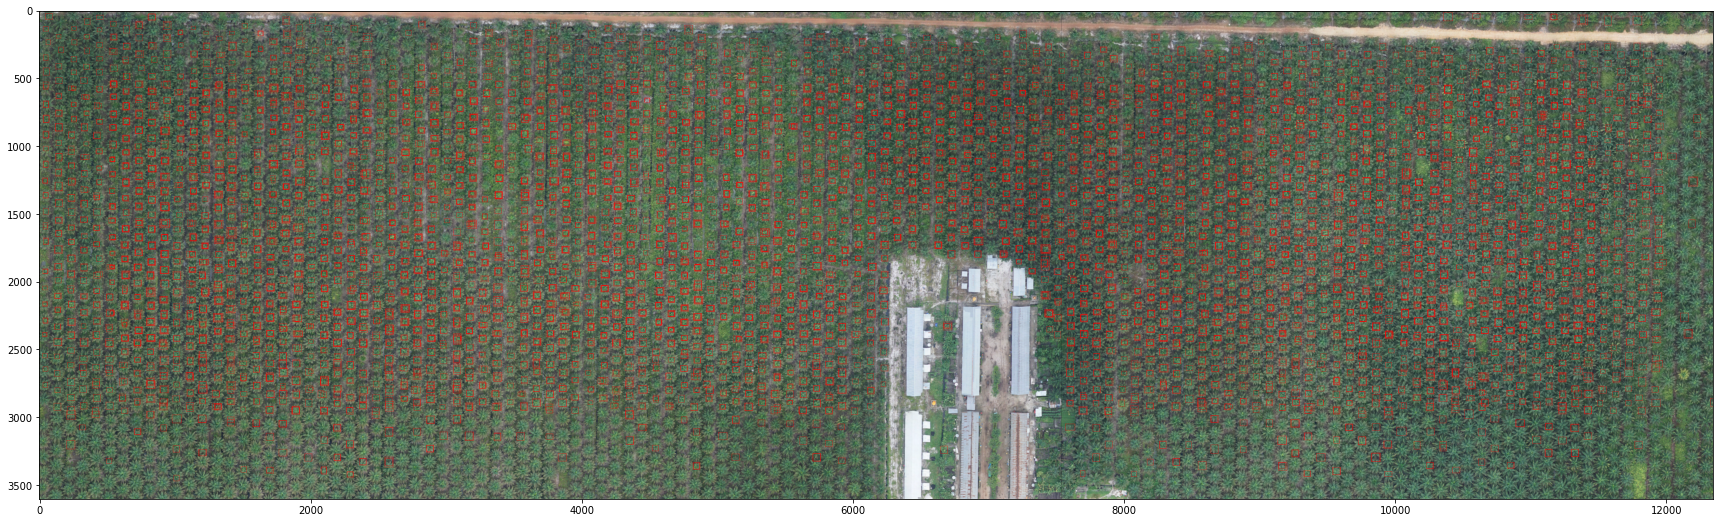

In [586]:
pixels = draw_bboxes(path, bbox)
plt.figure(figsize = (30,15))
plt.imshow(pixels)